<h3>Nama kelompok :
    <li>Fransiskus Riswan Indra Simbolon
    <li>Exelindo Yeremia
    <li>Annisa Ramadhani
    <li>Wafiq Muharnisa Haspin
    <li>Arza Muhammad Prihandoyo
    <li>Yusuf Natanael

In [1]:
!pip -q install speechRecognition

In [2]:
!pip -q install gtts

In [3]:
from urllib import request
!wget --no-check-certificate \
  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip

In [4]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [5]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [45]:
# Importing the dataset
with open('museum.json') as content:
  data1 = json.load(content)
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})


In [46]:
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [47]:
# Lematisasi atau Lemmatization
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

39 unique lemmatized words ['afternoon', 'apa', 'bai', 'bangunan', 'bro', 'bye', 'byee', 'dadah', 'dah', 'dari', 'deli', 'didirikan', 'filosofi', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hy', 'itu', 'jumpa', 'kapan', 'kawan', 'malam', 'morning', 'musebot', 'museum', 'pagi', 'sampai', 'see', 'selamat', 'serdang', 'si', 'siang', 'siapa', 'sore', 'tinggal', 'you']


In [48]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

5 classes ['MuseBot', 'filosofi', 'goodbye', 'greeting', 'kapan']


In [49]:
# documents = combination between patterns and intents
print (len(documents), "documents")

318 documents


In [50]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [1, 23, 5],
 [24, 5],
 [1, 6, 25, 26, 2, 3, 4],
 [1, 6, 2, 3, 4],
 [27, 28, 2, 3, 4],
 [],
 [29],
 [30],
 [7],
 [31],
 [32, 7],
 [33, 34],
 [35, 36],
 [37],
 [38, 39]]

In [51]:
# Apply padding 
MuseBot_train = pad_sequences(train)
print(MuseBot_train) # Padding Sequences

[[ 0  0  0  0  0  0  8]
 [ 0  0  0  0  0  0  9]
 [ 0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0 11]
 [ 0  0  0  0  0  0 12]
 [ 0  0  0  0  0  0 13]
 [ 0  0  0  0  0  0 14]
 [ 0  0  0  0  0  0 15]
 [ 0  0  0  0  0  0 16]
 [ 0  0  0  0  0  0 17]
 [ 0  0  0  0  0  0 18]
 [ 0  0  0  0  0  0 19]
 [ 0  0  0  0  0  0 20]
 [ 0  0  0  0  0  0 21]
 [ 0  0  0  0  0  0 22]
 [ 0  0  0  0  1 23  5]
 [ 0  0  0  0  0 24  5]
 [ 1  6 25 26  2  3  4]
 [ 0  0  1  6  2  3  4]
 [ 0  0 27 28  2  3  4]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 29]
 [ 0  0  0  0  0  0 30]
 [ 0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0 31]
 [ 0  0  0  0  0 32  7]
 [ 0  0  0  0  0 33 34]
 [ 0  0  0  0  0 35 36]
 [ 0  0  0  0  0  0 37]
 [ 0  0  0  0  0 38 39]]


In [52]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 1 1 4 4 2 2 2 2 2 2 2 2 2]


In [53]:
input_shape = MuseBot_train.shape[1]
print(input_shape)

7


In [54]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  39
output length:  5


In [55]:
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [56]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

In [57]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
MuseBot = Embedding(vocabulary+1,10)(i) # Layer Embedding
MuseBot = LSTM(10, return_sequences=True)(MuseBot) # Layer Long Short Term Memory
MuseBot = Flatten()(MuseBot) # Layer Flatten
MuseBot = Dense(output_length, activation="softmax")(MuseBot) # Layer Dense
model  = Model(i,MuseBot)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [58]:
# Menampilkan Parameter Model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 7)]               0         
                                                                 
 embedding_2 (Embedding)     (None, 7, 10)             400       
                                                                 
 lstm_2 (LSTM)               (None, 7, 10)             840       
                                                                 
 flatten_2 (Flatten)         (None, 70)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 355       
                                                                 
Total params: 1,595
Trainable params: 1,595
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Training the model (Latih model data sampai 400 kali)
train = model.fit(MuseBot_train, y_train, epochs=400)

Epoch 1/400
1/1 [==============================] - 1s 1s/step - loss: 1.5978 - accuracy: 0.4333
Epoch 2/400
1/1 [==============================] - 0s 13ms/step - loss: 1.5938 - accuracy: 0.5000
Epoch 3/400
1/1 [==============================] - 0s 8ms/step - loss: 1.5896 - accuracy: 0.5000
Epoch 4/400
1/1 [==============================] - 0s 8ms/step - loss: 1.5854 - accuracy: 0.5000
Epoch 5/400
1/1 [==============================] - 0s 9ms/step - loss: 1.5810 - accuracy: 0.5000
Epoch 6/400
1/1 [==============================] - 0s 6ms/step - loss: 1.5766 - accuracy: 0.5000
Epoch 7/400
1/1 [==============================] - 0s 8ms/step - loss: 1.5720 - accuracy: 0.5000
Epoch 8/400
1/1 [==============================] - 0s 18ms/step - loss: 1.5673 - accuracy: 0.5000
Epoch 9/400
1/1 [==============================] - 0s 7ms/step - loss: 1.5625 - accuracy: 0.5000
Epoch 10/400
1/1 [==============================] - 0s 8ms/step - loss: 1.5576 - accuracy: 0.5000
Epoch 11/400
1/1 [==========

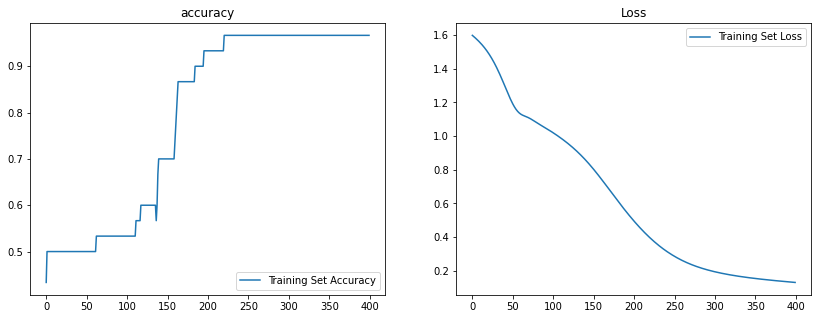

In [60]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [61]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)


  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 MuseBot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')

  # Simpan model voice bot ke dalam Google Drive
  tts.save('MuseBot.wav')
  time.sleep(0.08)
  
  # Load model voice bot from Google Drive
  ipd.display(ipd.Audio('MuseBot.wav', autoplay=False))
  print("="*60 + "\n")

  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : halo
🤖 MuseBot :  Horas! MuseBot di sini. Mau tau informasi tentang apa nih?



👨‍🦰 Kamu : apa itu musebot
🤖 MuseBot :  MuseBot adalah sebuat sistem layanan berbasis digital untuk membantu pengunjung untuk mengetahui apa saja layanan yang ada pada Museum ini .



👨‍🦰 Kamu : apa filosofi dari museum deli serdang
🤖 MuseBot :  filosofi dari bangunan museum Deli Serdang diambil dari konsep Itik Pulang Petang dari filosofi masyarakat Melayu. Ornamen 'Itik Pulang Petang' bermakna kepatuhan dan perlambang kebaikan, dimana unsur-unsur teratur, rapi dan harmonis tercermin dari bentuknya.



👨‍🦰 Kamu : oke bye
🤖 MuseBot :  Dahh, semoga harimu menyenangkan yaa!
